<a href="https://colab.research.google.com/github/roberto-bramucci/progetto-Bramucci-Bonci/blob/master/Copia_di_progetto_CV%26DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp  /content/drive/MyDrive/training_set.zip /content/
!unzip /content/training_set.zip -d /content/

Output streaming troncato alle ultime 5000 righe.
   creating: /content/training_set/51/14311/
  inflating: /content/training_set/51/14311/1_20210903_0.jpg  
   creating: /content/training_set/51/14312/
  inflating: /content/training_set/51/14312/1_20210903_0.jpg  
  inflating: /content/training_set/51/14312/4307_20220314_1.jpg  
   creating: /content/training_set/51/14313/
  inflating: /content/training_set/51/14313/1_20210903_0.jpg  
  inflating: /content/training_set/51/14313/1_20210903_1.jpg  
   creating: /content/training_set/51/14314/
  inflating: /content/training_set/51/14314/1_20210903_0.jpg  
  inflating: /content/training_set/51/14314/1_20210903_1.jpg  
   creating: /content/training_set/51/14315/
  inflating: /content/training_set/51/14315/64_20220118_0.jpg  
   creating: /content/training_set/51/14316/
  inflating: /content/training_set/51/14316/64_20220118_0.jpg  
  inflating: /content/training_set/51/14316/64_20220118_1.jpg  
   creating: /content/training_set/51/14317/

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime, os
from pathlib import Path
import numpy as np
import random
import pandas as pd
import glob
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from numba import jit
import keras.layers

In [ ]:
target_shape = (224,224)
embedding_size = 256
batch_size = 64
num_epochs = 20

In [ ]:
embeddingNet = tf.keras.models.load_model('/content/drive/MyDrive/Modelli Esame Settembre/bs64_lr00001_epoch30_XceptionNew')

In [ ]:
base_cnn = tf.keras.applications.Xception(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)
flatten = tf.keras.layers.Flatten()(base_cnn.output)
dense1 = tf.keras.layers.Dense(embedding_size)(flatten) 
output = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) (dense1) 
embeddingNet = tf.keras.Model(base_cnn.input, output, name="Embedding")

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
def read_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    image = tf.keras.applications.xception.preprocess_input(image)
    return image

In [ ]:
data_dir = "/content/training_set/"
data_dir = Path(data_dir)
list_ds = tf.data.Dataset.list_files(str(data_dir/'**/**/*.jpg'), shuffle=False)
image_count = len(list_ds)
label_list = []
for i in (list_ds):
    label_list = label_list + [int(i.numpy().decode().split('/')[-2])]

label_list_tf = tf.data.Dataset.from_tensor_slices(label_list)
dataset = list_ds.map(read_image)
dataset = tf.data.Dataset.zip((dataset, label_list_tf))
dataset = dataset.shuffle(buffer_size=1024)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"),
  tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(factor = 0.25)
])

In [ ]:
logdir = os.path.join("/content/drive/MyDrive/training_set", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Modelli Esame Settembre/bs64_lr00001_epoch30_XceptionNew', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=7, verbose=1, mode="auto", baseline=None, restore_best_weights=False)

In [ ]:
embeddingNet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tfa.losses.TripletHardLoss(soft=True))

In [ ]:
history = embeddingNet.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[tensorboard_callback,model_checkpoint_callback,early_stopping_callback])

Epoch 1/20
566/566 [==============================] - ETA: 0s - loss: 0.2883
Epoch 1: val_loss improved from inf to 0.32608, saving model to /content/drive/MyDrive/Modelli Esame Settembre/bs64_lr00001_epoch30_XceptionNew
566/566 [==============================] - 791s 1s/step - loss: 0.2883 - val_loss: 0.3261
Epoch 2/20
566/566 [==============================] - ETA: 0s - loss: 0.2806
Epoch 2: val_loss did not improve from 0.32608
566/566 [==============================] - 739s 1s/step - loss: 0.2806 - val_loss: 0.3266
Epoch 3/20
566/566 [==============================] - ETA: 0s - loss: 0.2783
Epoch 3: val_loss improved from 0.32608 to 0.30951, saving model to /content/drive/MyDrive/Modelli Esame Settembre/bs64_lr00001_epoch30_XceptionNew
566/566 [==============================] - 755s 1s/step - loss: 0.2783 - val_loss: 0.3095
Epoch 4/20
566/566 [==============================] - ETA: 0s - loss: 0.2760
Epoch 4: val_loss did not improve from 0.30951
566/566 [===========================

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
embeddingNet = tf.keras.models.load_model('/content/drive/MyDrive/Modelli Esame Settembre/bs64_lr00001_epoch30_Xception')

In [ ]:
embeddingNet.summary()

Model: "Embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
!cp  /content/drive/MyDrive/gallery.zip /content/
!unzip /content/gallery.zip -d /content/

Output streaming troncato alle ultime 5000 righe.
   creating: /content/gallery/51/14311/
  inflating: /content/gallery/51/14311/1_20210903_0.jpg  
   creating: /content/gallery/51/14312/
  inflating: /content/gallery/51/14312/1_20210903_0.jpg  
  inflating: /content/gallery/51/14312/4307_20220314_1.jpg  
   creating: /content/gallery/51/14313/
  inflating: /content/gallery/51/14313/1_20210903_0.jpg  
  inflating: /content/gallery/51/14313/1_20210903_1.jpg  
   creating: /content/gallery/51/14314/
  inflating: /content/gallery/51/14314/1_20210903_0.jpg  
  inflating: /content/gallery/51/14314/1_20210903_1.jpg  
   creating: /content/gallery/51/14315/
  inflating: /content/gallery/51/14315/64_20220118_0.jpg  
   creating: /content/gallery/51/14316/
  inflating: /content/gallery/51/14316/64_20220118_0.jpg  
  inflating: /content/gallery/51/14316/64_20220118_1.jpg  
   creating: /content/gallery/51/14317/
  inflating: /content/gallery/51/14317/64_20220118_0.jpg  
  inflating: /content/gal

In [ ]:
data_dir = "/content/gallery"
data_dir = Path(data_dir)
list_ds = tf.data.Dataset.list_files(str(data_dir/'**/**/*.jpg'), shuffle=False)
image_count = len(list_ds)
label_list = []
for i in (list_ds):
    label_list = label_list + [int(i.numpy().decode().split('/')[-2])]

label_list_tf = tf.data.Dataset.from_tensor_slices(label_list)
completeDataset = list_ds.map(read_image)

completeDataset = completeDataset.batch(batch_size, drop_remainder=False)
completeDataset = completeDataset.prefetch(8)

In [ ]:
from tensorflow.keras.callbacks import Callback
import time
class PredictionCallback(Callback):
    start_time = time.time()
    
    def on_predict_begin(self, logs=None):
        self.start_time = time.time()
        print("Starting prediction ...")
      
    def on_predict_end(self, logs=None):
        end_time = time.time()-self.start_time
        print(f"Inference time per Image: {end_time/image_count} seconds")

In [ ]:
embeddingTotale = embeddingNet.predict(completeDataset, callbacks=[PredictionCallback()])

Starting prediction ...
Inference time per Image: 0.004300016531935955 seconds


In [ ]:
list_all_images_for_embedding = (list(list_ds.as_numpy_iterator()))

In [ ]:
numFotoTotale = len(list_all_images_for_embedding)

In [ ]:
EANTotale = []
imageTotale = []
cat_totale = []
for i in list_all_images_for_embedding:
  EANTotale = EANTotale + [i.decode('UTF-8').split('/')[-2]]
  cat_totale = cat_totale + [i.decode('UTF-8').split('/')[-3]]
  imageTotale = imageTotale + [i.decode('UTF-8').split('/')[-1].split('.')[0]]

In [ ]:
EAN_imageTotale = []
for i in range(numFotoTotale):
  EAN_imageTotale = EAN_imageTotale + [EANTotale[i] + "_" + imageTotale[i] + "_" + cat_totale[i]]

In [ ]:
dictTotale = {key: [] for key in EAN_imageTotale}
for k, v in zip(EAN_imageTotale, embeddingTotale):
    dictTotale[k].append(v)

In [ ]:
!cp  /content/drive/MyDrive/test_set.zip /content/
!unzip /content/test_set.zip -d /content/

Archive:  /content/test_set.zip
   creating: /content/test_set/1/
   creating: /content/test_set/1/1/
  inflating: /content/test_set/1/1/41_20210614_2.jpg  
   creating: /content/test_set/1/113/
  inflating: /content/test_set/1/113/41_20210614_2.jpg  
   creating: /content/test_set/1/129/
  inflating: /content/test_set/1/129/56_20211110_1.jpg  
   creating: /content/test_set/1/145/
  inflating: /content/test_set/1/145/41_20210614_1.jpg  
   creating: /content/test_set/1/161/
  inflating: /content/test_set/1/161/56_20211110_1.jpg  
   creating: /content/test_set/1/17/
  inflating: /content/test_set/1/17/1_20210903_1.jpg  
   creating: /content/test_set/1/177/
  inflating: /content/test_set/1/177/56_20211110_2.jpg  
   creating: /content/test_set/1/213/
  inflating: /content/test_set/1/213/1_20210903_1.jpg  
   creating: /content/test_set/1/241/
  inflating: /content/test_set/1/241/41_20210614_3.jpg  
   creating: /content/test_set/1/257/
  inflating: /content/test_set/1/257/56_20211110_

In [ ]:
data_dirTest = "/content/test_set/"
data_dirTest = Path(data_dirTest)
list_dsTest = tf.data.Dataset.list_files(str(data_dirTest/'**/**/*.jpg'), shuffle=False)
image_countTest = len(list_dsTest)
EANListTest = []
imageListTest = []
for i in (list_dsTest):
    EANListTest = EANListTest + [int(i.numpy().decode().split('/')[-2])]
    imageListTest = imageListTest + [i.numpy().decode().split('/')[-1]]

datasetTest = list_dsTest.map(read_image)

datasetTest = datasetTest.batch(batch_size, drop_remainder=False)
datasetTest = datasetTest.prefetch(8)

In [ ]:
from tensorflow.keras.callbacks import Callback
import time
class PredictionCallback(Callback):
    start_time = time.time()
    
    def on_predict_begin(self, logs=None):
        self.start_time = time.time()
        print("Starting prediction ...")
    
    def on_predict_end(self, logs=None):
        end_time = time.time()-self.start_time
        print(f"Inference time: {end_time/image_countTest} seconds")

In [ ]:
embeddingTest = embeddingNet.predict(datasetTest, callbacks=[PredictionCallback()])

Starting prediction ...
Inference time: 0.006001576872915946 seconds


In [ ]:
pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import faiss 

index = faiss.IndexFlatIP(embedding_size)    # build the index
faiss.normalize_L2(embeddingTotale)
#index = faiss.IndexFlatL2(embedding_size)   # build the index
print(index.is_trained)
index.add(embeddingTotale)                  # add vectors to the index
print(index.ntotal)

k = 10                          # we want to see 4 nearest neighbors
D, I = index.search(embeddingTest, k) # sanity check


True
45277


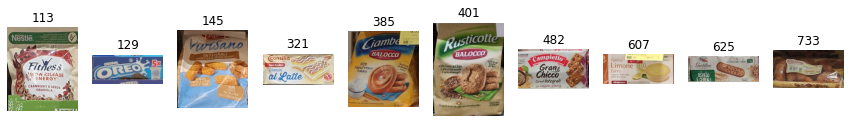

[1, 2, 3, 13, 18, 19, 24, 32, 33, 39]


In [ ]:
list_test_path = (list(list_dsTest.as_numpy_iterator()))
fig = plt.figure(figsize=(15, 15))
i = 0
count = 1
columns = 10
rows = 1
first_10_failed = []
while count < 11:
  if(EANListTest[i]!=label_list[I[i][0]] and EANListTest[i]!=label_list[I[i][1]] and EANListTest[i]!=label_list[I[i][2]] and EANListTest[i]!=label_list[I[i][3]] and EANListTest[i]!=label_list[I[i][4]] and EANListTest[i]!=label_list[I[i][5]] and EANListTest[i]!=label_list[I[i][6]] and EANListTest[i]!=label_list[I[i][7]] and EANListTest[i]!=label_list[I[i][8]] and EANListTest[i]!=label_list[I[i][9]]):
      pic_name = list_test_path[i].decode('UTF-8')
      image = plt.imread(pic_name)
      fig.add_subplot(rows, columns, count)
      plt.axis('off')
      plt.title(EANListTest[i])
      plt.imshow(image)
      first_10_failed = first_10_failed + [i]
      i = i+1
      count = count+1
  else:
      i = i+1
      count = count
plt.show()
print(first_10_failed)

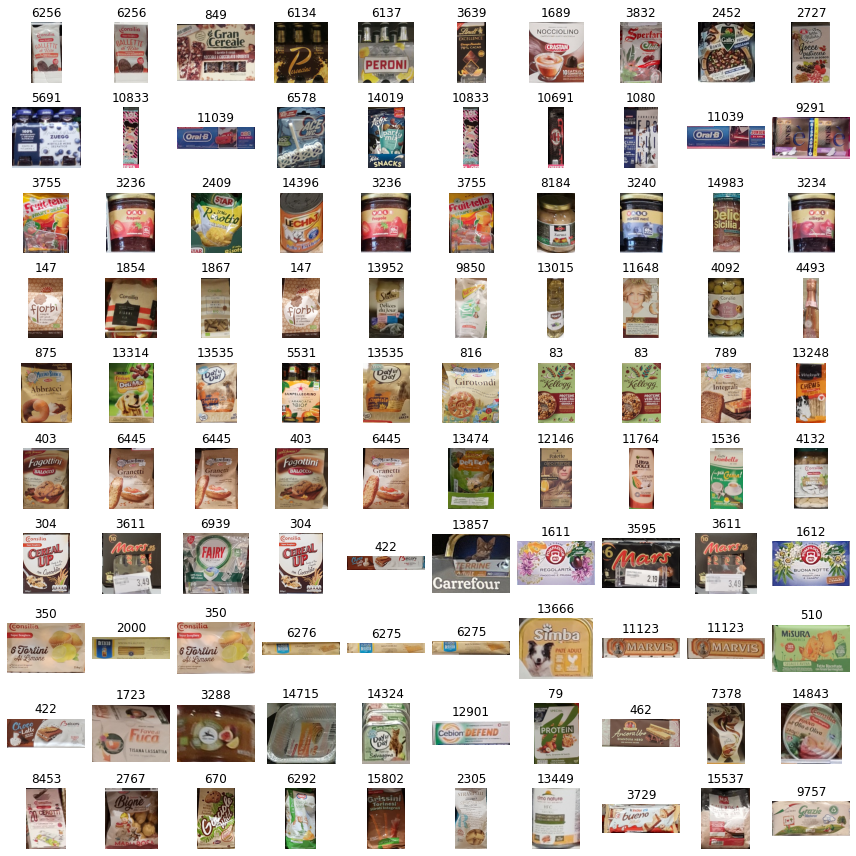

In [ ]:
list_gallery_path = (list(list_ds.as_numpy_iterator()))
i = 0
count = 1
failed_prediction = []
fig = plt.figure(figsize=(12, 12))
columns = 10
rows = 10
while count < 11:
  if(EANListTest[i]!=label_list[I[i][0]] and EANListTest[i]!=label_list[I[i][1]] and EANListTest[i]!=label_list[I[i][2]] and EANListTest[i]!=label_list[I[i][3]] and EANListTest[i]!=label_list[I[i][4]] and EANListTest[i]!=label_list[I[i][5]] and EANListTest[i]!=label_list[I[i][6]] and EANListTest[i]!=label_list[I[i][7]] and EANListTest[i]!=label_list[I[i][8]] and EANListTest[i]!=label_list[I[i][9]]):
    for j in range(1, columns +1):
       pic_name = list_gallery_path[I[i][j-1]].decode('UTF-8')
       image = plt.imread(pic_name)
       fig.add_subplot(rows, columns, 10*(count-1)+j)
       plt.axis('off')
       plt.title(label_list[I[i][j-1]])
       plt.imshow(image)
    failed_prediction = failed_prediction + [i] 
    i = i+1
    count = count+1
  else:
    i = i+1
    count = count

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()

In [ ]:
totaleCountTop5 = len(EANListTest)
countTop5 = 0
for i in range (totaleCountTop5):
  if(EANListTest[i]==label_list[I[i][0]] or EANListTest[i]==label_list[I[i][1]] or EANListTest[i]==label_list[I[i][2]] or EANListTest[i]==label_list[I[i][3]] or EANListTest[i]==label_list[I[i][4]]):
    countTop5 = countTop5 + 1
print(countTop5/totaleCountTop5) 


0.9126691266912669


In [ ]:
totaleCountTop10 = len(EANListTest)
countTop10 = 0
for i in range (totaleCountTop5):
  if(EANListTest[i]==label_list[I[i][0]] or EANListTest[i]==label_list[I[i][1]] or EANListTest[i]==label_list[I[i][2]] or EANListTest[i]==label_list[I[i][3]] or EANListTest[i]==label_list[I[i][4]] or EANListTest[i]==label_list[I[i][5]] or EANListTest[i]==label_list[I[i][6]] or EANListTest[i]==label_list[I[i][7]] or EANListTest[i]==label_list[I[i][8]] or EANListTest[i]==label_list[I[i][9]]):
    countTop10 = countTop10 + 1
print(countTop10/totaleCountTop10) 

0.9286592865928659


In [ ]:
totaleImgTest = len(EANListTest)
countAcc = 0
for i in range (totaleImgTest):
  if(EANListTest[i]==label_list[I[i][0]]):
    countAcc = countAcc + 1
print(countAcc/totaleImgTest)

0.8450184501845018


In [ ]:
@jit(nopython=True)
def fast_cosine(u, v):
    m = u.shape[0]
    udotv = 0
    u_norm = 0
    v_norm = 0
    for i in range(m):
        if (np.isnan(u[i])) or (np.isnan(v[i])):
            continue

        udotv += u[i] * v[i]
        u_norm += u[i] * u[i]
        v_norm += v[i] * v[i]

    u_norm = np.sqrt(u_norm)
    v_norm = np.sqrt(v_norm)

    if (u_norm == 0) or (v_norm == 0):
        ratio = 1.0
    else:
        ratio = udotv / (u_norm * v_norm)
    return ratio

In [ ]:
matching_EAN = []
matching_image = []
cosine_similarity_array = []
similarity_temp = -1
for i in embeddingTest:
	similarity_temp = -1
	for key, value in dictTotale.items():
		embedding_confronto = (((np.array(value, dtype = np.float32))))
		similarity = fast_cosine(np.array(i,dtype = np.float32), embedding_confronto[0])
		if similarity > similarity_temp:
			similarity_temp = similarity
			moreMatchingKey = key
	print(moreMatchingKey)
	matching_EAN = matching_EAN + [moreMatchingKey.split('_')[0]]
	matching_image = matching_image + [moreMatchingKey.split('_',1)[1] + '.jpg']
	cosine_similarity_array = cosine_similarity_array + [similarity_temp]

3525_41_20210614_2_2
9169_41_20210614_7_41
7913_41_20210614_0_37
860_1_20210903_0_1
14625_28_20210614_1_55
17_1_20210903_0_1
2816_56_20211110_3_16
213_1_20210903_0_1
238_41_20210614_4_1
257_56_20211110_4_1
274_41_20210614_0_1
289_41_20210614_8_1
305_56_20211110_3_1
9079_1_20210903_0_41
34_41_20210614_1_1
338_56_20211110_0_1
353_56_20211110_1_1
369_56_20211110_0_1
385_1_20210903_1_1
401_1_20210903_0_1
6338_1_20210903_1_3
433_41_20210614_1_1
449_41_20210614_0_1
9215_41_20210614_2_41
10550_28_20210614_1_42
496_41_20210614_0_1
513_56_20211110_2_1
529_41_20210614_2_1
15635_1_20210903_1_8
562_1_20210903_1_1
577_1_20210903_1_1
592_1_20210903_0_1
607_56_20211110_2_1
625_41_20210614_1_1
332_56_20211110_15_1
648_56_20211110_2_1
65_1_20210903_0_1
673_56_20211110_3_1
698_56_20211110_4_1
6993_1_20210903_1_33
8270_1_20210903_0_4
755_56_20211110_4_1
11044_41_20210614_6_43
785_41_20210614_2_1
8789_56_20211110_0_41
81_56_20211110_6_1
817_56_20211110_3_1
783_41_20210614_2_1
408_1_20210903_1_1
849_1_2021

In [ ]:
def create(lst):
    l = []
    for a, b, c, d in lst:
        l.append((float(a), b, c, d))
    return l

similarity_temp = []
EAN_temp = []
topN = []
topNTotale = []
count = 0
for i in embeddingTest:
	similarity_temp = []
	EAN_temp = []
	imagePath = []
	cat = []
	keyAttuale = list(EANListTest)[count]
	for key, value in dictTotale.items():
		embedding_confronto = (((np.array(value, dtype = np.float32))))
		similarity = fast_cosine(np.array(i), embedding_confronto[0])
		catTemp = key.split('_')[-1]
		PathTemp = '_'.join(key.split('_')[1:-1]) + '.jpg'
		if similarity > 0.2:
				similarity_temp = similarity_temp + [similarity]
				EAN_temp = EAN_temp + [key.split('_')[0]]
				imagePath = imagePath + [PathTemp]
				cat = cat + [catTemp]
	z = np.array(create(zip(similarity_temp,EAN_temp,imagePath,cat)))
	topN = z[np.argsort(z[:, 0].astype('float'))]
	topN = topN[-10:]
	topN = np.flip(topN, axis = 0)
	topN = list(topN)
	topN.append(keyAttuale)
	topN.append(imageListTest[count])
	count = count + 1
	print(count)
	topNTotale = topNTotale + [topN]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
totaleCountTop5 = len(topNTotale)
countTop5 = 0
for i in range(totaleCountTop5):
  if (topNTotale[i][0][1]==topNTotale[i][10] or topNTotale[i][1][1]==topNTotale[i][10] or topNTotale[i][2][1]==topNTotale[i][10] or topNTotale[i][3][1]==topNTotale[i][10] or topNTotale[i][4][1]==topNTotale[i][10]):
    countTop5 = countTop5 + 1
print(countTop5/totaleCountTop5)

0.0


In [ ]:
top10Totale = topNTotale
totaleCountTop10 = len(topNTotale)
countTop10 = 0
for i in range(totaleCountTop10):
  if (topNTotale[i][0][1]==topNTotale[i][10] or topNTotale[i][1][1]==topNTotale[i][10] or topNTotale[i][2][1]==topNTotale[i][10] or topNTotale[i][3][1]==topNTotale[i][10] or topNTotale[i][4][1]==topNTotale[i][10] or topNTotale[i][5][1]==topNTotale[i][10] or topNTotale[i][6][1]==topNTotale[i][10] or topNTotale[i][7][1]==topNTotale[i][10] or topNTotale[i][8][1]==topNTotale[i][10] or topNTotale[i][9][1]==topNTotale[i][10]):
    countTop10 = countTop10 + 1
print(countTop10/totaleCountTop10)

0.0


In [ ]:
resultCosineTest = pd.DataFrame({'EANTest': EANListTest, 'nameImageTest': imageListTest, 'matchingEAN': matching_EAN, 'nameImageMatch': matching_image, 'cosineSimilarity': cosine_similarity_array})

In [ ]:
comparison_column = np.where(resultCosineTest["EANTest"] == resultCosineTest["matchingEAN"], True, False)
resultCosineTest["Same"] = comparison_column
true_count = (resultCosineTest.Same).sum()
accuracy = true_count / len(resultCosineTest)

In [ ]:
print(accuracy)

0.0
